# Exercises 2.7 from the QuantChallenge

> Come up with a trading strategy that makes money between the day ahead hourly prices and the intraday hourly prices. A strategy could be something like, always buy hour 19-20 on day ahead and sell it on intraday. You can look at certain times, weekdays, seasons, production levels of wind and solar. Your strategy can have a few input paramters such as time, renewable production etc, and then a decision output between two prices. I.e. when do you want to go long and short. Show the cumulative performance of this strategy with a 100 MW position. Show your results and quickly explain your reasoning of why you think this strategy might be a good idea and why it does or does not work.

## Disclamer

I am not a specialist in energy trading (yet).
I enjoyed this exercise greatly and did a lot of research to improve my trading strategies as I found the process extremely rewarding.
I also took a few liberties, like assuming I can resize my position for some strategies (instead of always using 100 MW)

> This notebook shows the final result of this analysis that took quite a bit of time.

## Structure:
- Load and clean the data
- Resample the data to hourly frequncy as the task asks for _hourly prices_
- My approach to developing strategies (weather, momentum, volatility)
- Code
- Analysis of the best strategies


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [4]:
# load dataset (same as in previous notebook)
df = pd.read_excel("./database/analysis_task_data.xlsx")
# Convert the 'time' column to a datetime object
df['time'] = pd.to_datetime(df['time'])

print("Missing values:\n", df.isnull().sum())
print(f"unique time: {df['time'].is_unique}")
non_unique_values = df['time'].value_counts()[df['time'].value_counts() > 1].index.tolist()
print("Non-unique values:", non_unique_values)
print(f"Total values count {len(df)}")

df.drop_duplicates(subset='time', inplace=True, keep='first')
print(df.columns.tolist())

Missing values:
 hour                                                 0
time                                                 0
Wind Day Ahead Forecast [in MW]                      0
Wind Intraday Forecast [in MW]                       0
PV Day Ahead Forecast [in MW]                        0
PV Intraday Forecast [in MW]                         0
Day Ahead Price hourly [in EUR/MWh]                  0
Intraday Price Price Quarter Hourly  [in EUR/MWh]    0
Intraday Price Hourly  [in EUR/MWh]                  0
Imbalance Price Quarter Hourly  [in EUR/MWh]         0
dtype: int64
unique time: False
Non-unique values: [Timestamp('2021-10-31 02:45:00'), Timestamp('2021-10-31 02:30:00'), Timestamp('2021-10-31 02:15:00'), Timestamp('2021-10-31 02:00:00')]
Total values count 35040
['hour', 'time', 'Wind Day Ahead Forecast [in MW]', 'Wind Intraday Forecast [in MW]', 'PV Day Ahead Forecast [in MW]', 'PV Intraday Forecast [in MW]', 'Day Ahead Price hourly [in EUR/MWh]', 'Intraday Price Price Quarter 

In [5]:
# Set 'time' as the index for resampling
df.set_index('time', inplace=True)
# Resample to hourly using mean for continuous variables
df_hourly = df.resample('h').mean()
# Preserve 'Day Ahead price hourly' by forward-filling missing values
da_key = "Day Ahead Price hourly [in EUR/MWh]"
df_hourly[da_key] = df[da_key].resample('h').sum()/4. # since all 4 are the same
# Reset index to keep 'time' as a column
df_hourly.reset_index(inplace=True)

## Correlation Analysis

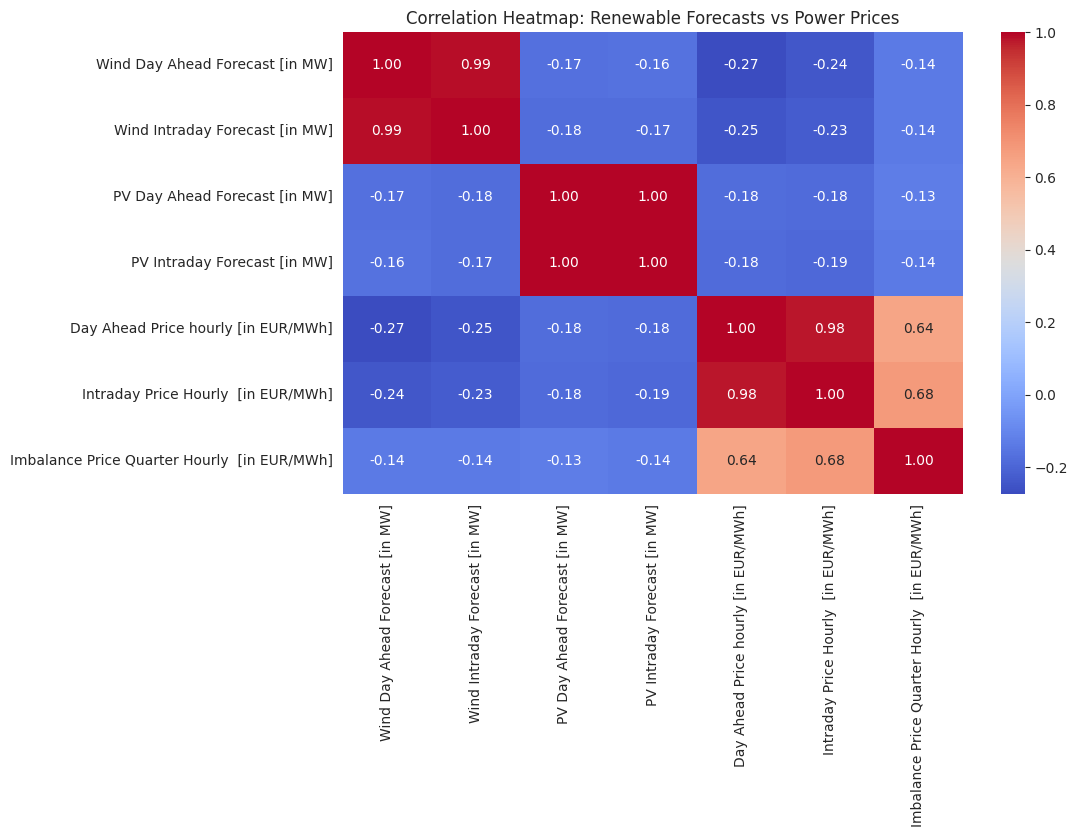

In [6]:
# Compute correlation matrix
correlation_matrix = df_hourly[[
    "Wind Day Ahead Forecast [in MW]",
    "Wind Intraday Forecast [in MW]",
    "PV Day Ahead Forecast [in MW]",
    "PV Intraday Forecast [in MW]",
    "Day Ahead Price hourly [in EUR/MWh]",
    "Intraday Price Hourly  [in EUR/MWh]",
    "Imbalance Price Quarter Hourly  [in EUR/MWh]"
]].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Renewable Forecasts vs Power Prices")
plt.show()

### Notes from the Correlation Heatmap:
1. Negative Correlation Between Wind Forecasts & Prices (merit order effect)
    - Both wind day-ahead and intraday wind forecasts are negatively correlated with day-ahead and intraday prices.
      This means that when more wind energy is forecasted, power prices tend to decrease.

2. Negative Correlation Between PV Forecasts & Prices
    - Similar to wind, PV (solar) forecasts show a negative correlation with prices, but it is weaker than wind. This suggests that high solar production also reduces prices but not as strongly as wind.

3. Strong Correlation Between Market Prices
    - The day-ahead price and intraday price are highly correlated, which is expected.
    - Imbalance price shows some correlation with intraday price but has more variance.


## Price Difference Analysis

In [7]:
# Calculate price differences between Day-Ahead and Intraday Hourly prices
df_hourly["Price Diff (Intraday - Day Ahead)"] = df_hourly["Intraday Price Hourly  [in EUR/MWh]"] - df_hourly["Day Ahead Price hourly [in EUR/MWh]"]
# Summary statistics of price differences
df_hourly["Price Diff (Intraday - Day Ahead)"].describe()

count    8759.000000
mean        1.140649
std        16.381785
min      -149.091700
25%        -5.132275
50%         0.163691
75%         6.436660
max       147.983032
Name: Price Diff (Intraday - Day Ahead), dtype: float64

### Key Observations from Price Differences:
- Mean Price Difference: ~1.14 EUR/MWh → On average, intraday prices are slightly higher than day-ahead prices.
- High Volatility: Standard deviation of ~16.38 EUR/MWh indicates significant fluctuations.
- Extreme Values: The price difference ranges from -149 EUR/MWh to +148 EUR/MWh, showing that large deviations occur.

## Trading Stratgies Development

Below is the result of several iterations/developments outside of this notebook.

I analyzed the correlation between renewable energy forecasts and power prices to develop multiple trading strategies. I first designed basic strategies based on wind and solar forecasts, incorporating price volatility to refine entry and exit conditions. I then introduced advanced strategies with risk-adjusted position sizing, leveraging forecast errors and dynamic volatility thresholds to optimize market exposure. Finally, I evaluated the strategies using cumulative profit analysis, volatility measures, and risk metrics such as Sharpe ratio and maximum drawdown to assess their performance and robustness.

After some reading on the matter I learned about __price drawdown__ that measures the peak-to-trough decline in a trading strategy’s cumulative profit that indicates the worst potential loss before recovery. I also read up on the __Sharpe ratio__ that evaluates risk-adjusted returns by comparing excess return over volatility, helping to assess whether a strategy's profits justify the risks taken. I included these metrics to ensure that the trading strategies not only generate returns but also manage downside risk effectively, maintaining a favorable risk-return balance.

## Code Structure

### Price difference

- Price Diff = Price Intraday - Price Day Ahead
- Compute rolling volatility if desired (e.g., rolling STD of 24 hours or 96 quarters).

#### Basic Strategies (1 - 5)

- Strategy 1 triggers a position when wind forecast exceeds the 75th percentile.
- Strategy 2 triggers a position when PV forecast exceeds the 75th percentile.
- Strategy 3 triggers when both wind & PV forecasts exceed the threshold.
- Strategy 4 refines Strategy 3 by also requiring low price volatility.
- Strategy 5 refines Strategy 3 by also requiring high price volatility.

#### Advanced Strategies (6 - 12)

- Strategy 6: Engage only under moderate (not too high, not too low) volatility and high wind+PV forecasts.
- Strategy 7: Position sizing depends on forecast error risk -- reduce or increase position based on high or low forecast error.
- Strategy 8: Peak hours strategy (e.g. 7 - 10h, 17 - 21h).
- Strategy 9: Momentum-based approach (if the rolling average of Price Diff is above a threshold, take a position).
- Strategy 10: Enhanced dynamic approach -- adjust position according to forecast error severity.
- Strategy 11 & 12: Position sizing based on volatility. In Strategy 12, the position is zero during very high volatility.
- Strategy 13 - 14: Combining momentum-based approach with renewables signals
- Strategy 15: attempt to combine momentum, volatility and renewables
- Strategy 19: "Forecast revisions strategy" attempt to resize the position based on mismatch between renewables forecast
#### Risk Metrics

For each strategy’s cumulative profit series, compute:
- Total Return
- Annualized Volatility
- Sharpe Ratio (simplified)
- Max Drawdown

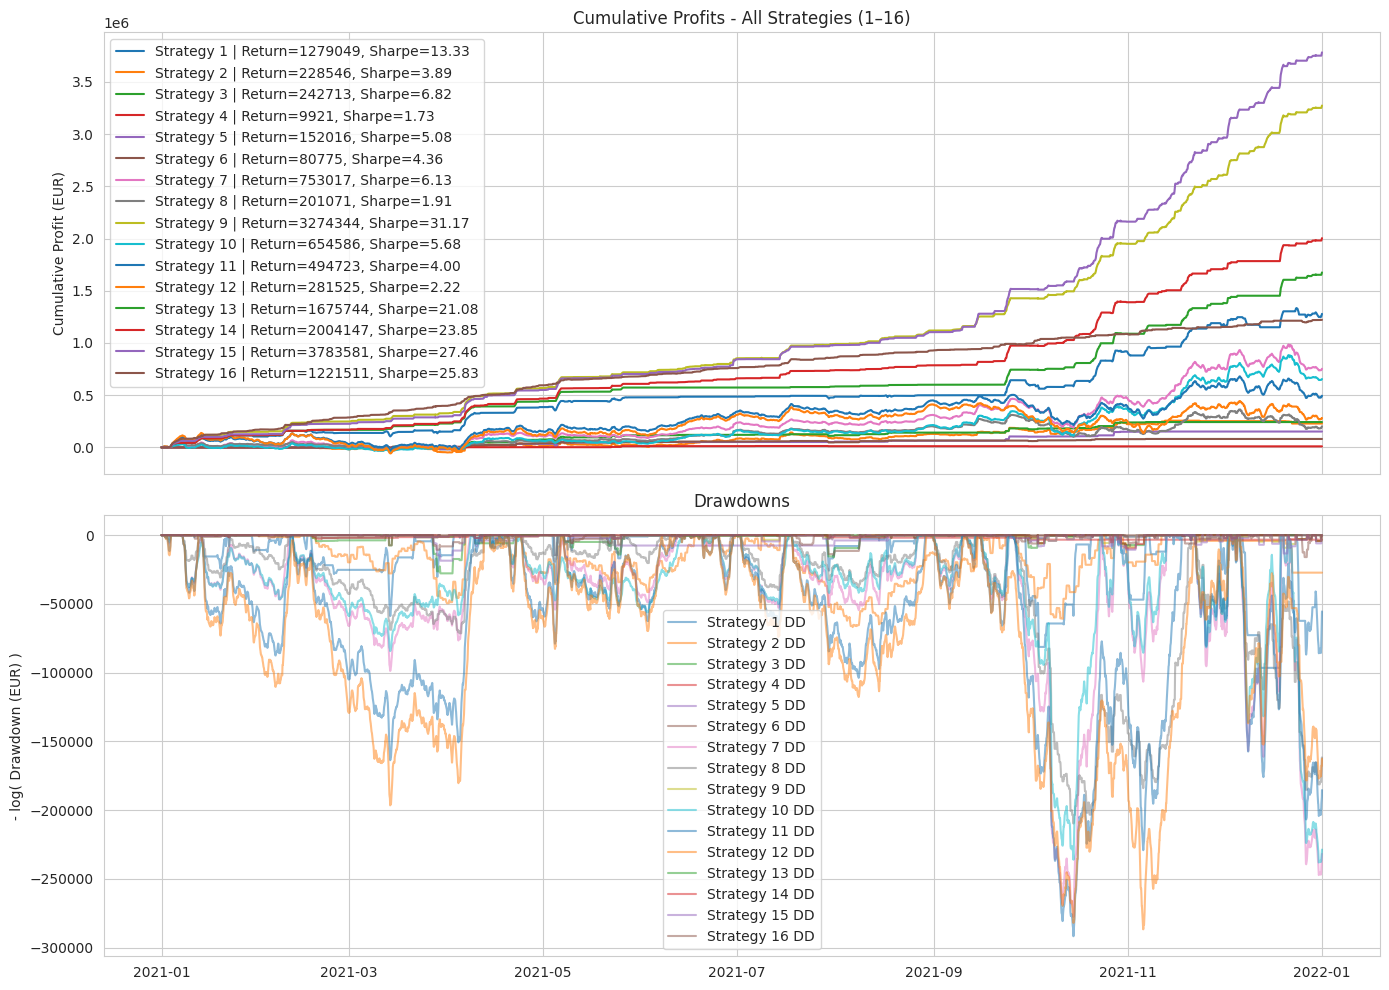

,Total Return (EUR),Annualized Volatility,Sharpe Ratio,Max Drawdown (EUR)
Strategy 1,1.279049e+06,19588.188199,13.330966,-96505.046647
Strategy 2,2.285461e+05,11991.800442,3.890973,-66856.229468
Strategy 3,2.427126e+05,7268.596798,6.817271,-27797.277362
Strategy 4,9.921456e+03,1171.183636,1.729494,-3318.641384
Strategy 5,1.520158e+05,6107.209431,5.081767,-18579.587115
Strategy 6,8.077534e+04,3781.760724,4.360673,-14558.910480
Strategy 7,7.530166e+05,25065.109856,6.133434,-277571.853326
Strategy 8,2.010713e+05,21518.950530,1.907646,-209700.641745
Strategy 9,3.274344e+06,21448.100726,31.167665,-9164.870938
Strategy 10,6.545856e+05,23526.563325,5.680372,-238033.550159


In [28]:
def calculate_risk_metrics(profit_series: pd.Series) -> dict:
    """
    Computes risk and performance metrics for a strategy's cumulative profit time series.
    """
    if len(profit_series) == 0:
        return {
            "Total Return (EUR)": 0,
            "Annualized Volatility": 0,
            "Sharpe Ratio": 0,
            "Max Drawdown (EUR)": 0
        }

    total_return = profit_series.iloc[-1]  # Final cumulative profit

    # daily returns as day-to-day changes in cumulative profit
    daily_returns = profit_series.diff().dropna()
    volatility = daily_returns.std()

    # Sharpe ratio (simple version, no risk-free rate)
    sharpe_ratio = 0 if volatility == 0 else total_return / (volatility * np.sqrt(len(daily_returns)))

    # Drawdown
    rolling_max = profit_series.cummax()
    drawdown = profit_series - rolling_max
    max_drawdown = drawdown.min() if len(drawdown) > 0 else 0

    return {
        "Total Return (EUR)": total_return,
        "Annualized Volatility": volatility * np.sqrt(365),
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown (EUR)": max_drawdown
    }
def compute_all_strategies(df: pd.DataFrame, position_size: int = 100) -> pd.DataFrame:
    """
    Defines and computes signals/positions and profits for strategies 1–15
    + adds a new Strategy 16 (Forecast Revisions + Vol Filter).
    Returns the dataframe with new columns for each strategy's signals/positions
    and cumulative profits.
    """


    # Basic Strategy thresholds
    high_wind_threshold = df["Wind Day Ahead Forecast [in MW]"].quantile(0.75)
    high_pv_threshold   = df["PV Day Ahead Forecast [in MW]"].quantile(0.75)

    if "Price Volatility" not in df.columns:
        raise ValueError("Column 'Price Volatility' not found in df. "
                         "Ensure you computed rolling volatility first.")
    low_vol_threshold  = df["Price Volatility"].quantile(0.25)
    high_vol_threshold = df["Price Volatility"].quantile(0.75)

    # Simple Strategies (1–5) -- I just tried to use renewables and volatility here

    # Strategy 1: High Wind Threshold
    df["Strategy 1 Signal"] = df["Wind Day Ahead Forecast [in MW]"] > high_wind_threshold

    # Strategy 2: High PV Threshold
    df["Strategy 2 Signal"] = df["PV Day Ahead Forecast [in MW]"] > high_pv_threshold

    # Strategy 3: High Wind AND High PV
    df["Strategy 3 Signal"] = df["Strategy 1 Signal"] & df["Strategy 2 Signal"]

    # Strategy 4: Strategy 3 + Low Volatility
    df["Strategy 4 Signal"] = df["Strategy 3 Signal"] & (df["Price Volatility"] < low_vol_threshold)

    # Strategy 5: Strategy 3 + High Volatility
    df["Strategy 5 Signal"] = df["Strategy 3 Signal"] & (df["Price Volatility"] > high_vol_threshold)


    # Forecast Error Columns -- I tried to use the mismatch between forecasts
    if ("Wind Intraday Forecast [in MW]" not in df.columns) or \
            ("PV Intraday Forecast [in MW]" not in df.columns):
        raise ValueError("Intraday Forecast columns missing. Check your dataset.")

    df["Wind Forecast Error"] = (
            df["Wind Intraday Forecast [in MW]"] - df["Wind Day Ahead Forecast [in MW]"]
    )
    df["PV Forecast Error"] = (
            df["PV Intraday Forecast [in MW]"] - df["PV Day Ahead Forecast [in MW]"]
    )

    df["Wind Forecast Error Abs"] = df["Wind Forecast Error"].abs()
    df["PV Forecast Error Abs"]   = df["PV Forecast Error"].abs()

    wind_err_75 = df["Wind Forecast Error Abs"].quantile(0.75)
    pv_err_75   = df["PV Forecast Error Abs"].quantile(0.75)
    wind_err_25 = df["Wind Forecast Error Abs"].quantile(0.25)
    pv_err_25   = df["PV Forecast Error Abs"].quantile(0.25)

    df["High Forecast Error"] = (
            (df["Wind Forecast Error Abs"] > wind_err_75)
            | (df["PV Forecast Error Abs"] > pv_err_75)
    )
    df["Low Forecast Error"] = (
            (df["Wind Forecast Error Abs"] < wind_err_25)
            & (df["PV Forecast Error Abs"] < pv_err_25)
    )

    # Additional (more complex) Strategies -- I tried to use volatility, posiiton resizing, errors
    moderate_volatility_mask = (
            (df["Price Volatility"] >= low_vol_threshold)
            & (df["Price Volatility"] <= high_vol_threshold)
    )
    df["Strategy 6 Signal"] = df["Strategy 3 Signal"] & moderate_volatility_mask

    # Strategy 7: Adjust position based on forecast error
    df["Strategy 7 Position"] = position_size
    df.loc[df["High Forecast Error"], "Strategy 7 Position"] *= 0.5
    df.loc[df["Low Forecast Error"],  "Strategy 7 Position"] *= 1.5

    # Strategy 8: Peak hours
    df["Hour"] = df["time"].dt.hour
    df["Strategy 8 Signal"] = (
            ((df["Hour"] >= 7) & (df["Hour"] <= 10))
            | ((df["Hour"] >= 17) & (df["Hour"] <= 21))
    )

    # Strategy 9: Momentum (somehow is the most performing strategy. I might be missing something...)
    if "Price Momentum" not in df.columns:
        raise ValueError("Column 'Price Momentum' not found. "
                         "Compute rolling momentum first.")
    momentum_threshold = df["Price Momentum"].quantile(0.75)
    df["Strategy 9 Signal"] = df["Price Momentum"] > momentum_threshold

    # Strategy 10: Enhanced dynamic risk (even more successfull, but hsould be very risky!)
    df["Strategy 10 Position"] = position_size
    df.loc[df["High Forecast Error"], "Strategy 10 Position"] *= 0.3
    df.loc[df["Low Forecast Error"],  "Strategy 10 Position"] *= 2.0

    # Strategy 11 & 12: Vol-based sizing (additional attempt)
    very_high_vol_threshold = df["Price Volatility"].quantile(0.90)

    df["Strategy 11 Position"] = position_size
    df.loc[df["Price Volatility"] > very_high_vol_threshold, "Strategy 11 Position"] = position_size * 0.3
    df.loc[df["Price Volatility"] < low_vol_threshold,       "Strategy 11 Position"] = position_size * 1.5

    df["Strategy 12 Position"] = position_size
    df.loc[df["Price Volatility"] > very_high_vol_threshold, "Strategy 12 Position"] = 0
    df.loc[df["Price Volatility"] < low_vol_threshold,       "Strategy 12 Position"] = position_size * 2.0

    # Strategy 13: Momentum + high wind (attempt to add generation signal to the most successfull one)
    df["Strategy 13 Signal"] = df["Strategy 9 Signal"] & (
            df["Wind Day Ahead Forecast [in MW]"] > high_wind_threshold
    )

    # Strategy 14: Momentum + (High wind OR High PV) (attempt to add generation signals to the most successfull one)
    df["Strategy 14 Signal"] = df["Strategy 9 Signal"] & (
            (df["Wind Day Ahead Forecast [in MW]"] > high_wind_threshold)
            | (df["PV Day Ahead Forecast [in MW]"] > high_pv_threshold)
    )

    # Strategy 15: Momentum + vol-based sizing (attempt to comvine momentum and volatility)
    df["Strategy 15 Position"] = position_size
    df.loc[df["Price Volatility"] > very_high_vol_threshold, "Strategy 15 Position"] *= 1.5
    df.loc[df["Price Volatility"] < low_vol_threshold,       "Strategy 15 Position"] *= 0.5
    df["Strategy 15 Position"] = df["Strategy 15 Position"] * df["Strategy 9 Signal"].astype(int)


    # Strategy 16 => Forecast Revisions + Vol Filter (attempt to be more market-informed...)

    # Compute Net Revision (Intraday - DayAhead)
    df["Delta Wind"] = df["Wind Intraday Forecast [in MW]"] - df["Wind Day Ahead Forecast [in MW]"]
    df["Delta PV"]   = df["PV Intraday Forecast [in MW]"]   - df["PV Day Ahead Forecast [in MW]"]
    df["Net Revision"] = df["Delta Wind"] + df["Delta PV"]

    # Shift Price Diff for causality (if not already)
    if "Price Diff Shifted" not in df.columns:
        df["Price Diff Shifted"] = df["Price Diff"].shift(1)

    #Additional rolling volatility for Strategy 16 (to avoid errors with naiming)
    df["Strategy 16 Vol"] = df["Price Volatility"]

    #Determine threshold for revision
    rev_threshold = df["Net Revision"].abs().quantile(0.75)
    strategy_16_vol_thresh = high_vol_threshold  # using the same threshold

    # Create signal: default zero
    df["Strategy 16 Signal"] = 0

    #   If NetRevision > +rev_threshold => short day-ahead => signal = -1
    df.loc[df["Net Revision"] > rev_threshold, "Strategy 16 Signal"] = -1
    #   If NetRevision < -rev_threshold => long day-ahead => signal = +1
    df.loc[df["Net Revision"] < -rev_threshold, "Strategy 16 Signal"] = 1

    # Vol Filter: skip trade if volatility is too high
    df.loc[df["Strategy 16 Vol"] > strategy_16_vol_thresh, "Strategy 16 Signal"] = 0


    # Compute Profits & Cumulative Profits for Strategies 1–16

    # Ensure 'Price Diff' is present
    if "Price Diff" not in df.columns:
        raise ValueError("Column 'Price Diff' not found in df. "
                         "Make sure you created it before computing strategies.")

    # Basic strategies 1–5, 6, 8, 9, 13, 14, 16 => use a Signal (bool or ±1)
    for i in [1,2,3,4,5,6,8,9,13,14,16]:
        sig_col = f"Strategy {i} Signal"
        profit_col = f"Strategy {i} Profit"
        cum_col = f"Cumulative Profit Strategy {i}"
        if sig_col in df.columns:
            df[profit_col] = df[sig_col].astype(int) * df["Price Diff"] * position_size
            df[cum_col] = df[profit_col].cumsum()

    # Strategies 7,10,11,12,15 => use a Position (float)
    for i in [7,10,11,12,15]:
        pos_col = f"Strategy {i} Position"
        profit_col = f"Strategy {i} Profit"
        cum_col = f"Cumulative Profit Strategy {i}"
        if pos_col in df.columns:
            df[profit_col] = df[pos_col] * df["Price Diff"]
            df[cum_col] = df[profit_col].cumsum()

    return df

def main(df_hourly, position_size: int = 100):
    """

    """

    #Create Price Diff if not already
    if "Price Diff" not in df_hourly.columns:
        df_hourly["Price Diff"] = (
                df_hourly["Intraday Price Hourly  [in EUR/MWh]"]
                - df_hourly["Day Ahead Price hourly [in EUR/MWh]"]
        )

    # Possibly define Price Diff Shifted, Price Volatility, Price Momentum, etc. rolling 6h for now
    if "Price Diff Shifted" not in df_hourly.columns:
        df_hourly["Price Diff Shifted"] = df_hourly["Price Diff"].shift(1)

    if "Price Volatility" not in df_hourly.columns:
        df_hourly["Price Volatility"] = df_hourly["Price Diff Shifted"].rolling(6, min_periods=1).std()

    if "Price Momentum" not in df_hourly.columns:
        df_hourly["Price Momentum"] = df_hourly["Price Diff Shifted"].rolling(6, min_periods=1).mean()

    # Compute all strategies (including new Strategy 16)
    df_hourly = compute_all_strategies(df_hourly, position_size)

    # Evaluate results => Sharpe, drawdown, etc.
    all_strats = [f"Strategy {i}" for i in range(1,17)]

    risk_metrics = {}
    for s in all_strats:
        cum_col = f"Cumulative Profit {s}"
        if cum_col in df_hourly.columns:
            risk_metrics[s] = calculate_risk_metrics(df_hourly[cum_col])

    #  Plot results
    fig, ax = plt.subplots(2,1, figsize=(14,10), sharex=True)

    # Cumulative Profits
    for s in risk_metrics.keys():
        cum_col = f"Cumulative Profit {s}"
        label = (f"{s} | "
                 f"Return={risk_metrics[s]['Total Return (EUR)']:.0f}, "
                 f"Sharpe={risk_metrics[s]['Sharpe Ratio']:.2f}")
        ax[0].plot(df_hourly["time"], df_hourly[cum_col], label=label)
    ax[0].legend()
    ax[0].set_title("Cumulative Profits - All Strategies (1–16)")
    ax[0].set_ylabel("Cumulative Profit (EUR)")

    #  Drawdown
    for s in risk_metrics.keys():
        cum_col = f"Cumulative Profit {s}"
        rolling_max = df_hourly[cum_col].cummax()
        drawdown = df_hourly[cum_col] - rolling_max
        # drawdown[drawdown >= 0] = 0.
        ax[1].plot(df_hourly["time"], drawdown, label=f"{s} DD", alpha=0.5)
    ax[1].legend()
    ax[1].set_title("Drawdowns")
    ax[1].set_ylabel("- log( Drawdown (EUR) )")

    plt.tight_layout()
    plt.show()

    # Print risk metrics table
    risk_df = pd.DataFrame(risk_metrics).T
    # print("Risk metrics (Strategies 1–16):\n", risk_df)

    return df_hourly, risk_df
df_hourly, risk_df = main(df_hourly)
risk_df

### Study Analysis

From the analysis, _Strategy 15_ emerges as the most profitable approach, yielding the highest total return of 3.7 million EUR while maintaining a strong Sharpe ratio of 27 and moderate drawdowns. This strategy is a momentum-based strategy with increased position during high volatility.

Momentum-based strategies (9, 13, 14, and 14) demonstrate good performance, with Strategy 9 (pure momentum-based) leading in risk-adjusted returns (Sharpe 31 for strategy) and Strategy 14 (momentum & weather) achieving a solid balance between profitability and risk. Notably, Strategy 13 and 14, which integrate momentum with renewable energy signals, significantly improve upon standalone renewable-based strategies like Strategy 1 or 2, achieving higher returns with lower drawdowns. Traditional renewable strategies (1-5) perform modestly, but their profitability is limited due to market volatility, as seen in Strategy 2 and 3, which exhibit relatively high drawdowns. Overall, integrating momentum and volatility control mechanisms (as in Strategy 14 and 15) leads to optimal profitability and risk mitigation, making them the most effective approaches for trading in volatile power markets. Strategy 16 was design to account for the error between forecasts more accurately.

These results require backtesting and further investigations. I am not convinced that pure momentum-driven strategy should always outperform generation-informed strategies with volatility corrections.







